Get data

In [39]:
import kachery_cloud as kcl
import spikeinterface as si
import probeinterface as pi

# Load recording
uri = 'ipfs://bafybeihqetpnwdiiujilgr4psqhjbriitaf2gk4ili3fjioonhfquj23ce?label=continuous_1min.dat?label=hackathon_example_data_allen/Neuropix-PXI-100_ProbeA-AP/continuous_1min.dat'
fname = kcl.load_file(uri)

rec = si.BinaryRecordingExtractor(fname, sampling_frequency=30000, num_chan=384, dtype='int16')
probe_group = pi.read_probeinterface("/Users/kyu/repos/spike-sorting-hackathon/datasets/examples/NP1_standard_config.json")
rec = rec.set_probegroup(probe_group)
print(rec)

# Print recording information
print('')
print(f'Sampling frequency (Hz): {rec.get_sampling_frequency()}')
print(f'Duration (minutes): {rec.get_total_duration() / 60}')
print(f'Num. channels: {rec.get_num_channels()}')


BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 60.000s
  file_paths: ['/Users/kyu/.kachery-cloud/ipfs/uj/23/ce/bafybeihqetpnwdiiujilgr4psqhjbriitaf2gk4ili3fjioonhfquj23ce']

Sampling frequency (Hz): 30000
Duration (minutes): 1.0
Num. channels: 384


Load model

In [40]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

path_to_model = './2020_02_29_15_28_unet_single_ephys_1024_mean_squared_error-1050.h5'

# def annealed_loss(y_true, y_pred):
#     if not K.is_tensor(y_pred):
#         y_pred = K.constant(y_pred)
#     y_true = K.cast(y_true, y_pred.dtype)
#     local_power = 4
#     final_loss = K.pow(K.abs(y_pred - y_true) + 0.00000001, local_power)
#     return K.mean(final_loss, axis=-1)

# model = load_model(
#             filepath=path_to_model,
#             custom_objects={
#                 "annealed_loss": annealed_loss}
#         )

model = load_model(filepath=path_to_model)

get the mean and std of the data to standardize it, reshape data

In [41]:
# get the mean and std of the data
import numpy as np
import spikeinterface.toolkit as st
filtered_rec = st.bandpass_filter(rec, freq_min=300, freq_max=5000)

# We calculate the mean and std of the data
average_nb_samples = 200000
raw_data = filtered_rec.get_traces()

shape = (int(rec.get_num_frames()), int(384 / 2), 2)
# load it with the correct shape
raw_data = np.reshape(raw_data, newshape=shape)

local_data = raw_data[0:average_nb_samples, :, :].flatten()
local_mean = np.mean(local_data)
local_std = np.std(local_data)

function that changes the data to the form the model takes and then standardizes it

In [42]:
def get_input(index_frame, raw_data, local_mean, local_std):

    nb_probes = 384
    pre_frame = 30
    post_frame = 30
    pre_post_omission = 1
    
    # We reorganize to follow true geometry of probe for convolution
    input_full = np.zeros(
        [1, nb_probes, 2,
         pre_frame + post_frame], dtype="float32"
    )

    input_index = np.arange(
        index_frame - pre_frame - pre_post_omission,
        index_frame + post_frame + pre_post_omission + 1,
    )
    input_index = input_index[input_index != index_frame]

    for index_padding in np.arange(pre_post_omission + 1):
        input_index = input_index[input_index !=
                                  index_frame - index_padding]
        input_index = input_index[input_index !=
                                  index_frame + index_padding]

    data_img_input = raw_data[input_index, :, :]
    
    data_img_input = np.swapaxes(data_img_input, 1, 2)
    data_img_input = np.swapaxes(data_img_input, 0, 2)

    even = np.arange(0, nb_probes, 2)
    odd = even + 1
        
    data_img_input = (
        data_img_input.astype("float32") - local_mean
    ) / local_std
    
    input_full[0, even, 0, :] = data_img_input[:, 0, :]
    input_full[0, odd, 1, :] = data_img_input[:, 1, :]
    return input_full

function to change the shape back

In [43]:
def get_output(di_frame, local_mean, local_std):
    nb_probes=384
    even = np.arange(0, nb_probes, 2)
    odd = even + 1
    reshaped_frame = np.zeros((384,))
    reshaped_frame[0::2] = di_frame[0,even,0,0]
    reshaped_frame[1::2] = di_frame[0,odd,1,0]
    reshaped_frame = reshaped_frame*local_std+local_mean
    return reshaped_frame


Example: predict frame index 80

In [44]:
k = get_input(80, raw_data, local_mean, local_std)
predicted_frame = model.predict(k)
out_frame = get_output(predicted_frame, local_mean, local_std)

1/1 [==============================] - 0s 116ms/step


Try for many frames

In [63]:
start_frame = 1500
end_frame = 2000
post_DI = np.zeros((end_frame-start_frame, 384))
for i in range(start_frame, end_frame):
    input_frame = get_input(i, raw_data, local_mean, local_std)
    predicted_frame = model.predict(input_frame, verbose=False)
    out_frame = get_output(predicted_frame, local_mean, local_std)
    post_DI[i-start_frame] = out_frame

In [72]:
input_frame.shape

(1, 384, 2, 60)

visualize output

In [64]:
import matplotlib.pyplot as plt

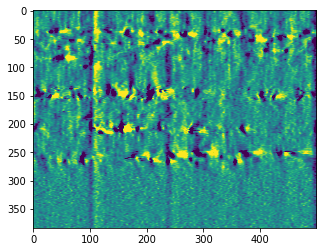

In [65]:
# before DI
pre_DI = filtered_rec.get_traces(start_frame=start_frame, end_frame=end_frame)
plt.imshow(pre_DI.T, vmin=-200, vmax=200)

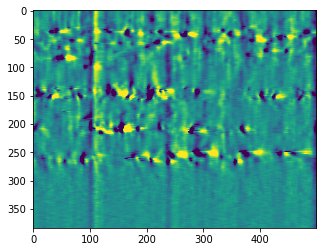

In [66]:
# after DI
plt.imshow(post_DI.T,vmin=-200, vmax=200)

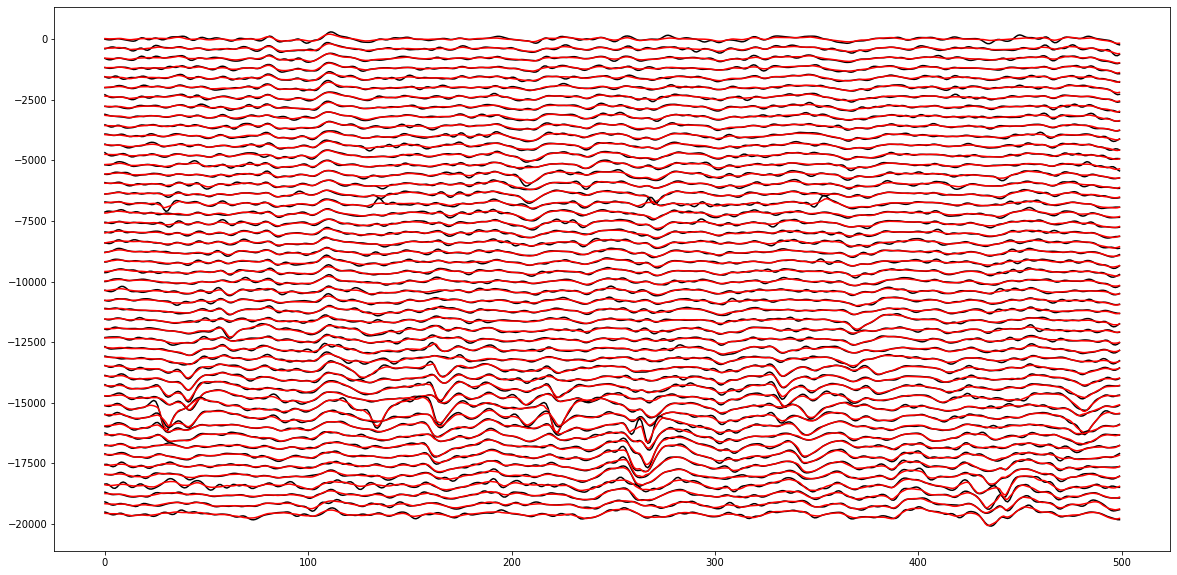

In [68]:
fig, ax = plt.subplots(figsize=(20,10))
for i in range(50):
    ax.plot(pre_DI[:,i]-i*400, 'k')
    ax.plot(post_DI[:,i]-i*400, 'r')

Spikeinterface class

In [77]:
from spikeinterface.core.baserecording import BaseRecording, BaseRecordingSegment

class DeepInterpolatedRecording(BaseRecording):
    
    def __init__(self, recording, path_to_model, 
                 pre_frames=30, post_frames=30, pre_post_omission=1, 
                 n_frames_normalize=20000):
        
        self.pre_frames = pre_frames
        self.post_frames = post_frames
        self.pre_post_omission = pre_post_omission
        
        # load model
        from tensorflow.keras.models import load_model

        self.model = load_model(filepath=path_to_model)
        
        # estimate mean and std
        if n_frames_normalize > recording.get_num_frames():
            print('Too few frames; using all frames to estimate mean and std')
            n_frames_normalize = recording.get_num_frames()
            
        local_data = recording.get_traces(start_frame=0, 
                                          end_frame=n_frames_normalize)

        self.local_mean = np.mean(local_data.flatten())
        self.local_std = np.std(local_data.flatten())
        
class DeepInterpolatedRecordingSegment(BaseRecordingSegment):
    
    def __init__(self, recording_segment, channel_indices):
        BaseRecordingSegment.__init__(self, **recording_segment.get_times_kwargs())
        self.recording_segment = recording_segment
        
    def get_num_samples(self):
        return self.recording_segment.get_num_samples()
        
    def get_traces(self, start_frame, end_frame, channel_indices):
        
        assert len(channel_indices)==384, "DeepInterpolatedRecording currently only works with NP 1.0 type probes"
        

        raw_data = self.recording_segment.get_traces(start_frame-self.pre_frames, 
                                                   end_frame+self.post_frames, 
                                                   channel_indices)
        
        shape = (end_frame-start_frame+self.pre_frames+self.post_frames, int(384 / 2), 2)
        
        # load it with the correct shape
        raw_data = np.reshape(raw_data, newshape=shape)
        di_input = np.zeros((end_frame-start_frame, 384, 2, self.pre_frames+self.post_frames))
        
        for index_frame in range(start_frame, end_frame):
            di_frame[index_frame-start_frame] = get_input(index_frame, raw_data, self.local_mean, self.local_std)
        
        di_output = model.predict(di_input, verbose=False)
        
        out_traces = np.zeros((end_frame-start_frame,384))
        for i in range(di_output.shape[0]):
            out_traces[i] = get_output(di_output[i], self.local_mean, self.local_std)
        
        return traces

In [79]:
di_rec = DeepInterpolatedRecording(filtered_rec, path_to_model=path_to_model)

In [80]:
di_rec.get_traces(start_frame = 1500, end_frame = 2000)

AttributeError: 'DeepInterpolatedRecording' object has no attribute '_recording_segments'

visualize model

In [3]:
import tensorflow as tf

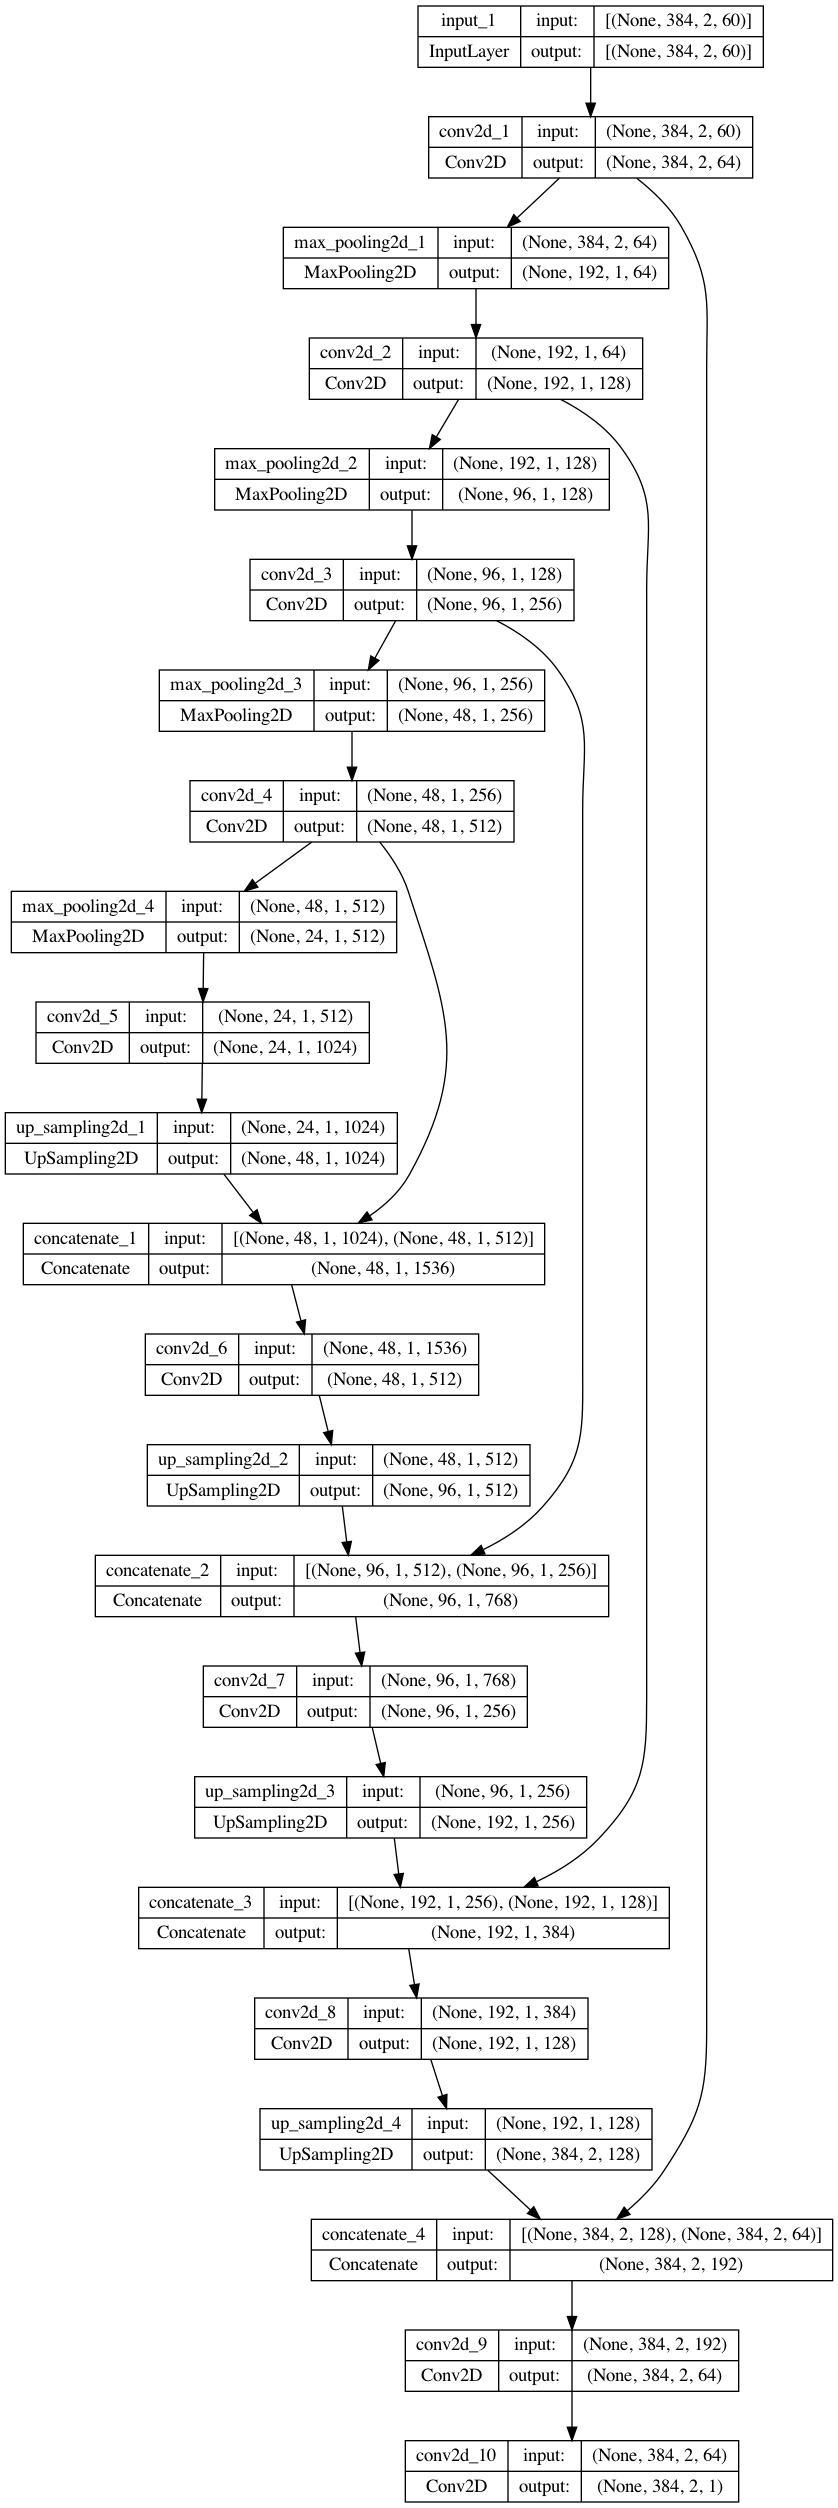

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)